# **5. Modeling**

<u> **User Definfed Functions**

In [ ]:
def create_submission_file_threshold(test_data,test_orders,model) :
  test_data = test_data[test_data['in_last_order'] == 1]
  test_data = test_data.groupby(['order_id'])['product_id'].apply(lambda k: " ".join(list(map(str, k.tolist())))).reset_index(name = "products")
  submission = pd.merge(test_orders,test_data, on = 'order_id', how = 'left')
  submission['order_id'] = submission['order_id'].apply(int)
  submission = submission.where(pd.notnull(submission), 'None')
  submission.to_csv("/content/drive/MyDrive/submissions/submission_threshold_{}.csv".format(model), index= False)


In [ ]:
def create_submission_f1_optimized(orders,best_products,model):
  orders['products']= best_products
  orders['order_id'] = orders['order_id'].apply(int)
  orders.drop(['product_id','y_prob'], axis = 1, inplace = True)
  orders.to_csv("/content/drive/MyDrive/submissions/submission_f1opt_{}.csv".format(model), index= False)

### *Splitting Train dataset to train and validation sets*

In [ ]:
#splitting the train dataset by users in the ratio 0.8 :0.2 for train and validation respectively.
train_users_all = train_data.user_id.drop_duplicates()
train_users = train_users_all.sample(frac = 0.8)

val_users = train_users_all.drop(train_users.index)
X_train  = train_data[train_data.user_id.isin(train_users)]
X_val = train_data[train_data.user_id.isin(val_users)]

train_data = X_train[['order_id','user_id','product_id','product_name','in_last_order']] 
val_data = X_val[['order_id','user_id','product_id','product_name','in_last_order']]
y_train = X_train['in_last_order']
y_val = X_val['in_last_order']
#removing columns that are not used in modeling step
X_train = X_train.drop(columns = [ 'product_name','department','aisle','order_id','eval_set','order_dow','order_hour_of_day','product_id','order_id','user_id','in_last_order'])
X_val = X_val.drop(columns = [ 'product_name','department','aisle','order_id','eval_set','order_dow','order_hour_of_day','product_id','order_id','user_id','in_last_order'])
features = X_train.columns

### *Scaling the data*

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

### *Preparing test dataset*

In [ ]:
X_test = test_data.copy()
test_data  =  test_data[['order_id','user_id','product_id','product_name']]
X_test= X_test.drop(columns = [ 'product_name','department','aisle','order_id','eval_set','order_dow','order_hour_of_day','product_id','order_id','user_id'])
X_test = scaler.transform(X_test)

## **5.1.Baseline Model**

* In this model we will be repeating users previous order, this will be our baseline model to which we will compare the rest of the models.


In [ ]:
order_products_prior_merged = pd.read_pickle('/content/drive/MyDrive/Instacart/order_products_prior_merged.pickle')

In [ ]:
X_val_random = val_data.copy()[['order_id','user_id','product_id','product_name']]
idx = order_products_prior_merged.groupby('user_id')['order_number'].transform(max)  == order_products_prior_merged['order_number'] 
last1 = order_products_prior_merged[idx]
last1 = last1[['user_id','product_name']]
last1['in_last_order'] = 1
X_val_random = X_val_random.merge(last1, on = ['user_id','product_name'], how = 'left')
X_val_random.in_last_order.fillna(0,inplace = True)

y_pred_val = X_val_random['in_last_order']
y_val_pred = np.select( [X_val_random['in_last_order'] == 1, X_val_random['in_last_order'] == 0], [np.random.uniform(0.5,1), np.random.uniform(0,0.49)])

print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.6980522847012645


In [ ]:
test_orders = orders[orders['eval_set']=='test'][['order_id']]

In [ ]:
#test 
test_data = X_test.merge(last1, on = ['user_id','product_name'], how = 'left')
test_data.in_last_order.fillna(0,inplace = True)
create_submission_file_threshold(test_data,test_orders, model= 'random')

kaggle score

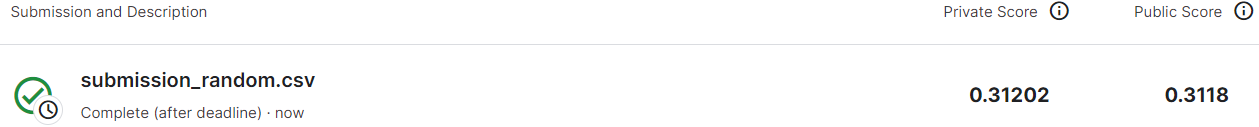

## **5.2.Logistic Regression**

***Training***

*Hyperparameter tuning*

In [ ]:
param_dist = {"C": [ 1e-4, 1e-3, 1e-2, 1e-1]}
clf = LogisticRegression()
lr_grid= GridSearchCV(clf, param_grid=param_dist,cv=2,scoring='neg_log_loss',return_train_score = True)
lr_grid.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1]},
             return_train_score=True, scoring='neg_log_loss')

In [ ]:
print(lr_grid.best_estimator_)

LogisticRegression(C=0.1)


*Training with best parameter*

In [ ]:
clf = LogisticRegression(C= 0.1)
clf.fit(X_train,y_train)

LogisticRegression(C=0.1)

***Validation***

In [ ]:
y_val_pred = clf.predict_proba(X_val)
print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.24774648334316168


*finding best threshold for classification*

In [ ]:
threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] 
for i in threshold :
  y_pred_val =  (y_val_pred[:,1]>= i).astype(int)
  print('Validation f1 score for ',i,f1_score(y_val,y_pred_val))

Validation f1 score for  0.1 0.3750793144753173
Validation f1 score for  0.2 0.433185510977243
Validation f1 score for  0.3 0.41486883625184523
Validation f1 score for  0.4 0.35853626710597136
Validation f1 score for  0.5 0.2837455797419222
Validation f1 score for  0.6 0.1965727322220206
Validation f1 score for  0.7 0.10974754361452002
Validation f1 score for  0.8 0.03513113492392399
Validation f1 score for  0.9 0.001824134140301284


***Feature importance - Top 20 features***

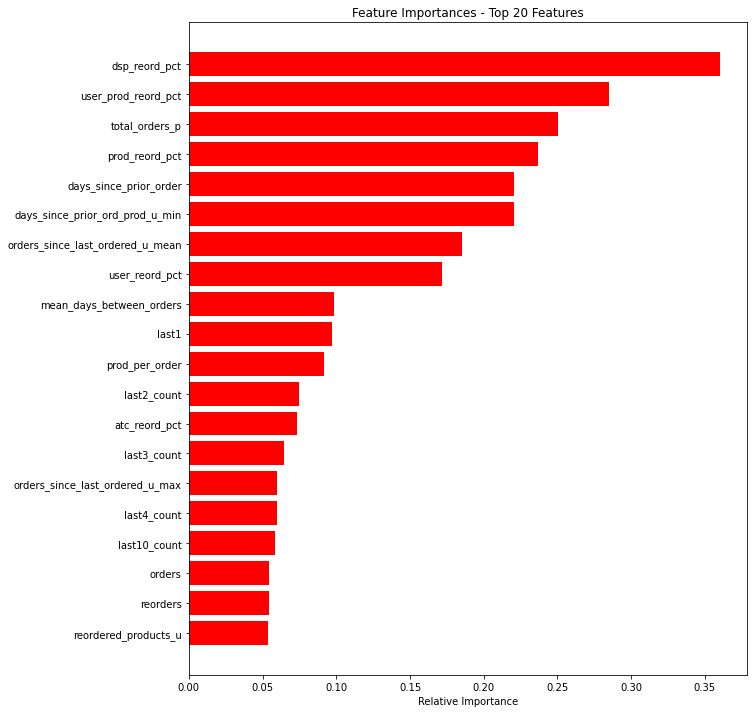

In [ ]:
importances = clf.coef_[0]
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - Top 20 Features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

***Test submission***

*Using fixed threshold of 0.2*

In [ ]:
orders = pd.read_csv('/content/drive/MyDrive/Instacart/orders.csv' )
test_orders = orders[orders['eval_set']=='test'][['order_id']]

In [ ]:
y_test_pred = clf.predict_proba(X_test)
test_data['in_last_order'] = (y_test_pred[:,1]>= 0.2).astype(int)
create_submission_file_threshold(test_data,test_orders,model= 'logistic_regression')

<u>kaggle score

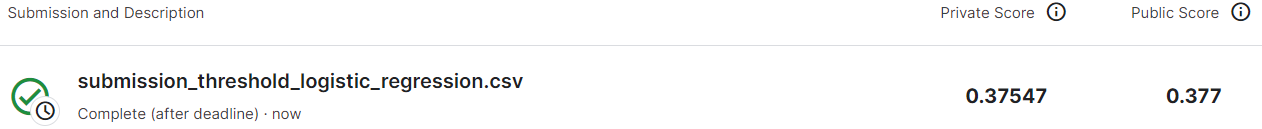

*using f1 optimization script*

In [ ]:
test_data['y_prob'] = clf.predict_proba(X_test)[:,1]
total_proc = 60
orders = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
def multi(i):
  prod = get_best_prediction(orders.iloc[i]['product_id'], orders.iloc[i]['y_prob'], None)
  return prod
pool = mp.Pool(total_proc)
best_products = pool.map(multi, range(orders.shape[0]))
create_submission_f1_optimized(orders,best_products,model = 'logistic_regression')

<u>kaggle score

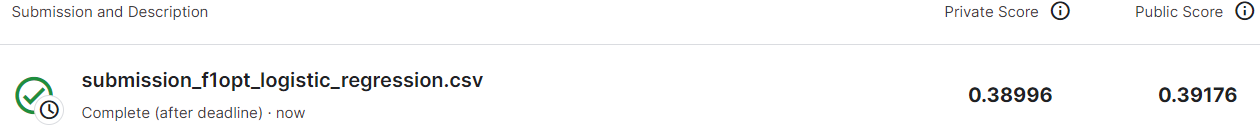

## **5.3 Decision Tree**


***Training***

*hyperparameter tuning* 

In [ ]:
max_depth = [3,5,7,9,11,13,15]
param_grid = {'max_depth': max_depth}
clf = DecisionTreeClassifier()
dt_grid= GridSearchCV(clf, param_grid=param_grid,cv=2,scoring='neg_log_loss',return_train_score = True)
dt_grid.fit(X_train,y_train)
print(dt_grid.best_estimator_)

DecisionTreeClassifier(max_depth=7)


In [ ]:
print(dt_grid.best_estimator_)

DecisionTreeClassifier(max_depth=7)


*Training with best parameter*

In [ ]:
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=7)

***Validation***

In [ ]:
y_val_pred = clf.predict_proba(X_val)
print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.24769147771493566


***Feature Importance - Top 20 Features***



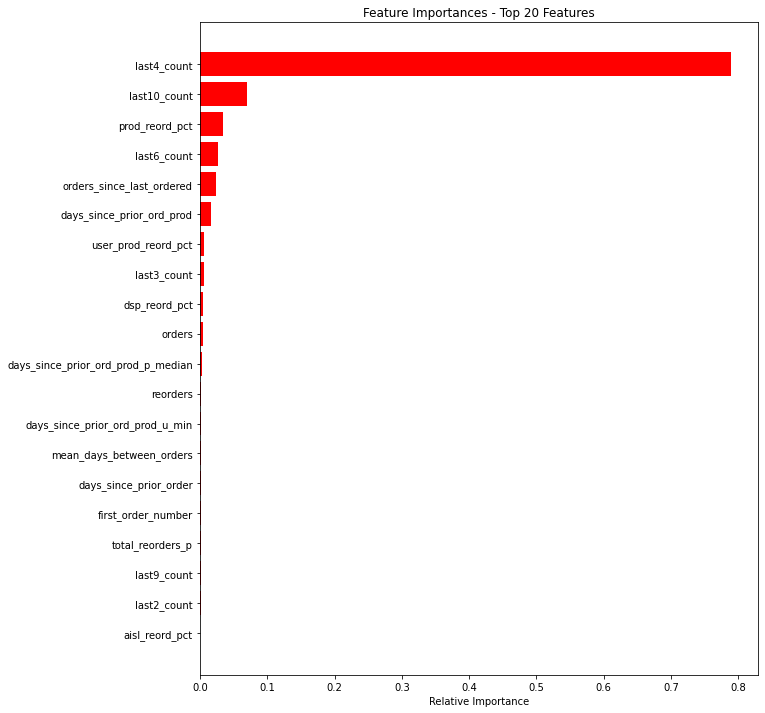

In [ ]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - Top 20 Features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

***Test Submission***

*Using fixed threshold of 0.2*

In [ ]:
y_test_pred = clf.predict_proba(X_test)
test_data['in_last_order'] = (y_test_pred[:,1]>= 0.2).astype(int)
create_submission_file_threshold(test_data,test_orders,model= 'decision_tree')

<u>kaggle score
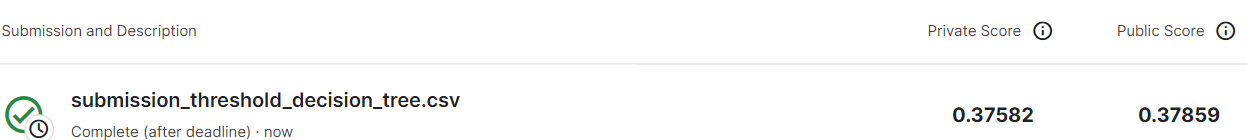

*using f1 optimization script*

In [ ]:
test_data['y_prob'] = clf.predict_proba(X_test)[:,1]
total_proc = 60
orders = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
def multi(i):
  prod = get_best_prediction(orders.iloc[i]['product_id'], orders.iloc[i]['y_prob'], None)
  return prod
pool = mp.Pool(total_proc)
best_products = pool.map(multi, range(orders.shape[0]))
create_submission_f1_optimized(orders,best_products,model = 'decision_tree')

<u>kagge score

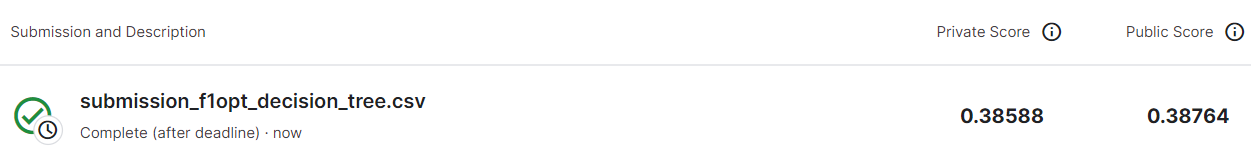

## **5.4 Random Forest**

***Training***

*Hyperparameter tuning*

In [ ]:
param_dist = {
              "n_estimators":sp_randint(20,35),
              "max_depth": sp_randint(10,20),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,45)}
clf = RandomForestClassifier(bootstrap = True)
rf_random = RandomizedSearchCV(clf, param_distributions =param_dist, n_iter = 10,cv=2,scoring='neg_log_loss',n_jobs = 2)
rf_random.fit(X_train,y_train)
print(rf_random.best_params_)

{'max_depth': 18, 'min_samples_leaf': 31, 'min_samples_split': 138, 'n_estimators': 27}


*Training with best parameter*

In [ ]:
clf = RandomForestClassifier(bootstrap = True,max_depth=18,n_estimators = 27,min_samples_split = 138,min_samples_leaf=31)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=18, min_samples_leaf=31, min_samples_split=138,
                       n_estimators=27)

***Feature Importance - Top 20 Features***

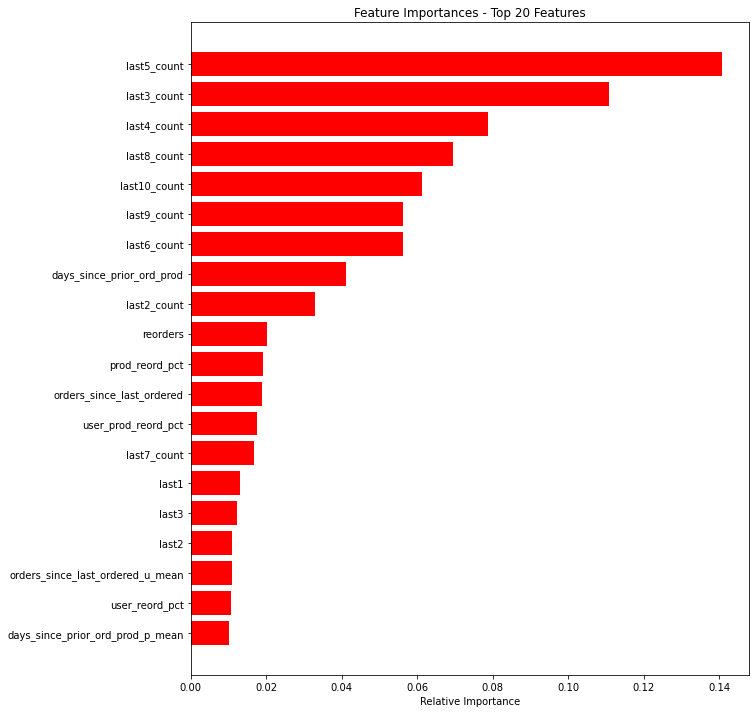

In [ ]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - Top 20 Features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

***Validation***

In [ ]:
y_val_pred = clf.predict_proba(X_val)
print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.24543084726413672


***Test Submission***

*Using fixed threshold of 0.2*

In [ ]:
y_test_pred = clf.predict_proba(X_test)
test_data['in_last_order'] = (y_test_pred[:,1]>= 0.2).astype(int)
create_submission_file_threshold(test_data,test_orders,model= 'random_forest')

<u>kaggle score

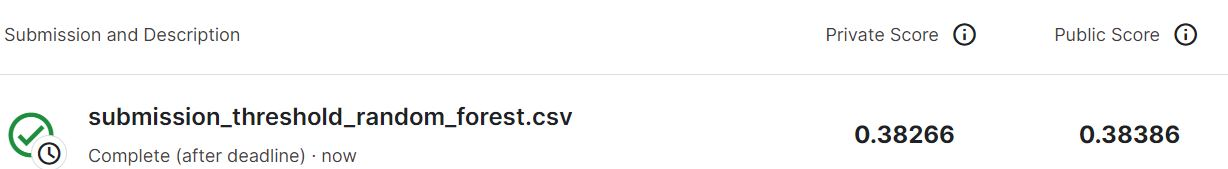

*using f1 optimization script*

In [ ]:
test_data['y_prob'] = clf.predict_proba(X_test)[:,1]
total_proc = 60
orders = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
def multi(i):
  prod = get_best_prediction(orders.iloc[i]['product_id'], orders.iloc[i]['y_prob'], None)
  return prod
pool = mp.Pool(total_proc)
best_products = pool.map(multi, range(orders.shape[0]))
create_submission_f1_optimized(orders,best_products,model = 'random_forest')

<u>kaggle score

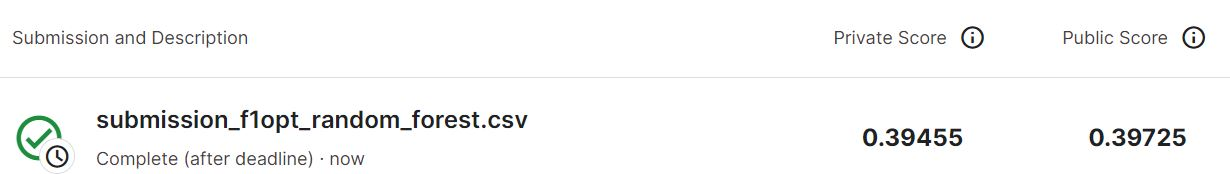

## **5.5 XgBoost**

***Training***

*Hyperparameter tuning*

In [ ]:
clf=XGBClassifier(eval_metric='logloss',objective='binary:logistic',
               tree_method='gpu_hist')
prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,110,120,130,140,150],
     'max_depth':[3,4,5,6,7,8,9,10],
}
xgb_random=RandomizedSearchCV(clf,param_distributions=prams,cv=2,scoring='neg_log_loss')
xgb_random.fit(X_train,y_train)
print(xgb_random.best_params_)

{'n_estimators': 130, 'max_depth': 6, 'learning_rate': 0.1}


*Training with best parameters*

In [ ]:
clf = XGBClassifier(eval_metric='logloss',objective='binary:logistic', n_estimators = 130, max_depth = 6 , learning_rate = 0.1,
               tree_method='gpu_hist')
clf.fit(X_train,y_train)

XGBClassifier(eval_metric='logloss', max_depth=6, n_estimators=130,
              tree_method='gpu_hist')

***Validation***

In [ ]:
y_val_pred = clf.predict_proba(X_val)
print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.24421497710261883


***Feature Importance - Top 20 Features***

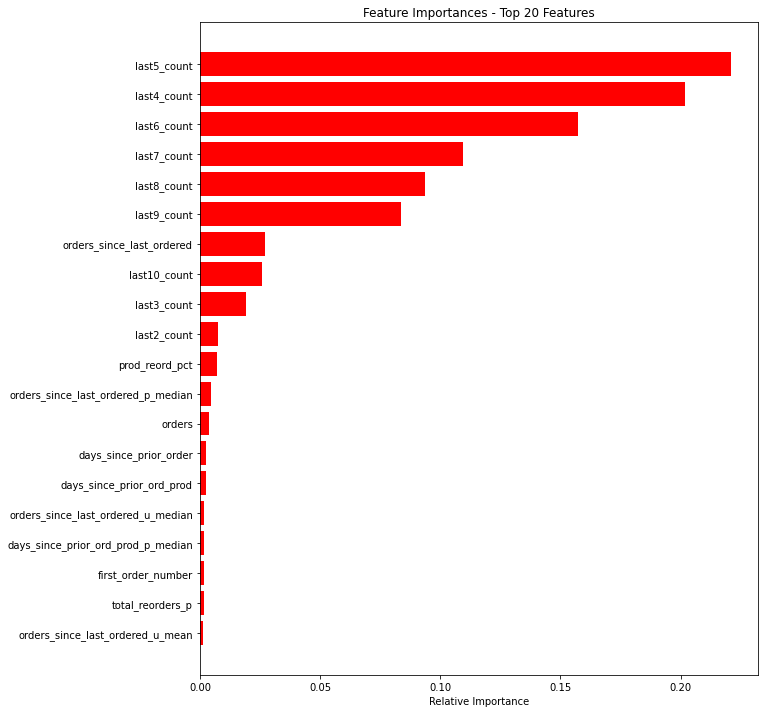

In [ ]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - Top 20 Features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

***Test Submission***

*Using fixed threshold of 0.2*

In [ ]:
y_test_pred = clf.predict_proba(X_test)
test_data['in_last_order'] = (y_test_pred[:,1]>= 0.2).astype(int)
create_submission_file_threshold(test_data,test_orders,model= 'xgboost')

<u>kaggle score

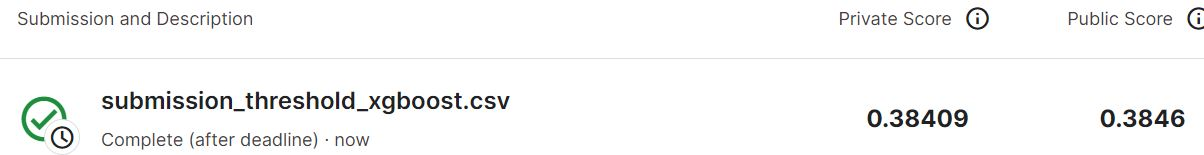

*using f1 optimization script*

In [ ]:
test_data['y_prob'] = clf.predict_proba(X_test)[:,1]
total_proc = 60
orders = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
def multi(i):
  prod = get_best_prediction(orders.iloc[i]['product_id'], orders.iloc[i]['y_prob'], None)
  return prod
pool = mp.Pool(total_proc)
best_products = pool.map(multi, range(orders.shape[0]))
create_submission_f1_optimized(orders,best_products,model = 'xgboost')

<u>kaggle score 

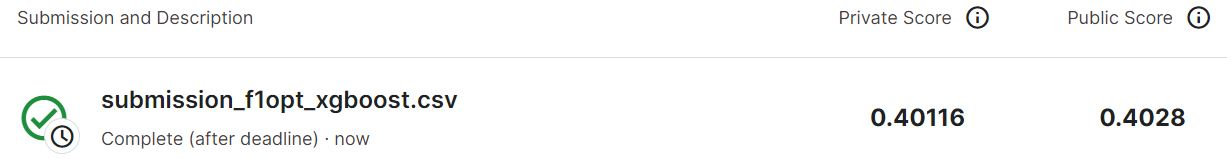

## **5.6 Catoost**

***Training***

*Hyperparameter tuning*

In [ ]:
clf=CatBoostClassifier(task_type = "GPU", silent = True,subsample = 0.85,boosting_type = 'Plain',bootstrap_type = 'Bernoulli' )
prams={
    'learning_rate':[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],
     'n_estimators':[3000,3100,3200,3300,3400,3500],
     'max_depth':[3,4,5,6,7,8,9,10],
}
cat_random=RandomizedSearchCV(clf,param_distributions=prams,cv=2,scoring='neg_log_loss')
cat_random.fit(X_train,y_train)
print(cat_random.best_params_)

{'n_estimators': 3300, 'max_depth': 3, 'learning_rate': 0.04}


*Training with best parameters*

In [ ]:
clf=CatBoostClassifier(task_type = "GPU", silent = True,subsample = 0.85,boosting_type = 'Plain',bootstrap_type = 'Bernoulli',max_depth = 3, n_estimators = 3000, learning_rate = 0.04 )
clf.fit(X_train,y_train)

***Validation***

In [ ]:
y_val_pred = clf.predict_proba(X_val)
print('Validation log loss',log_loss(y_val,y_val_pred, labels=[0,1], eps=1e-15))

Validation log loss 0.24457983484902399


***Feature Importance - Top 20 Features***

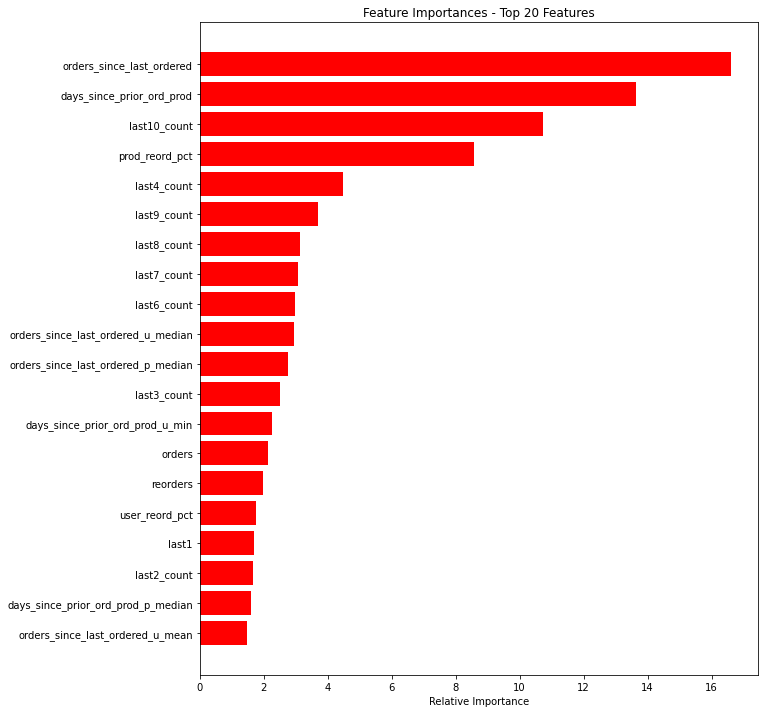

In [ ]:
importances = clf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances - Top 20 Features')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

*Using fixed threshold of 0.2*

In [ ]:
y_test_pred = clf.predict_proba(X_test)
test_data['in_last_order'] = (y_test_pred[:,1]>= 0.2).astype(int)
create_submission_file_threshold(test_data,test_orders,model= 'catboost')

<u>kaggle score

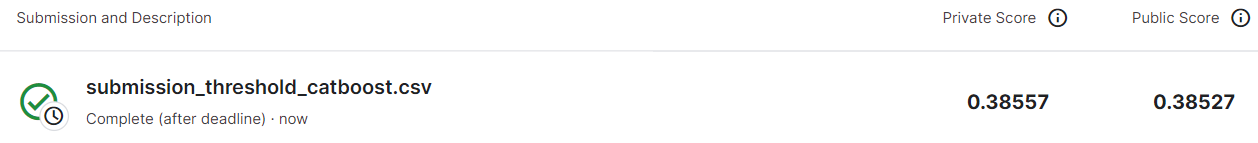

*using f1 optimization script*

In [ ]:
test_data['y_prob'] = clf.predict_proba(X_test)[:,1]
total_proc = 60
orders = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
def multi(i):
  prod = get_best_prediction(orders.iloc[i]['product_id'], orders.iloc[i]['y_prob'], None)
  return prod
pool = mp.Pool(total_proc)
best_products = pool.map(multi, range(orders.shape[0]))
create_submission_f1_optimized(orders,best_products,model = 'catboost')

<u>kaggle score

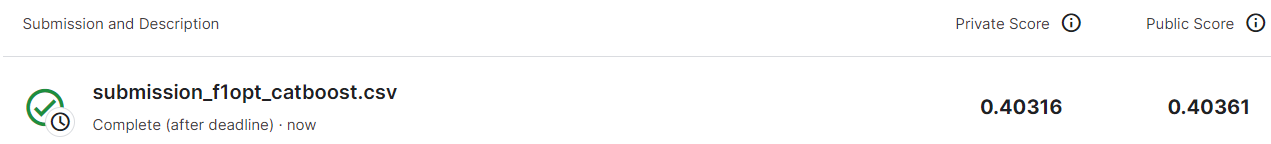

***Saving best model***

In [ ]:
clf.save_model('/content/drive/MyDrive/Instacart/catboost_model') 

## **5.6 Results**

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names  = ['Model' , 'Validation Log Loss',  'F1 Score - Fixed threshold(0.2)', 'F1 Score - Optimized']

table.add_row(['Baseline Model', 0.698,	0.31202,0.31202])
table.add_row(['Logistic Regression', 0.2477,	0.37547	,0.38996])
table.add_row(['Decision Tree', 0.2476,	0.37582	,0.38588])
table.add_row(['Random Forest', 0.2454,	0.38266,	0.39455])
table.add_row(['XgBoost',0.2442,	0.38409	,0.40116])
table.add_row(['Catboost', 0.2445,	0.38527,0.40316])

print(table)



+---------------------+---------------------+---------------------------------+----------------------+
|        Model        | Validation Log Loss | F1 Score - Fixed threshold(0.2) | F1 Score - Optimized |
+---------------------+---------------------+---------------------------------+----------------------+
|    Baseline Model   |        0.698        |             0.31202             |       0.31202        |
| Logistic Regression |        0.2477       |             0.37547             |       0.38996        |
|    Decision Tree    |        0.2476       |             0.37582             |       0.38588        |
|    Random Forest    |        0.2454       |             0.38266             |       0.39455        |
|       XgBoost       |        0.2442       |             0.38409             |       0.40116        |
|       Catboost      |        0.2445       |             0.38527             |       0.40316        |
+---------------------+---------------------+----------------------------

> Kaggle private results are listed above, the best score is in the 10th percentile of all submissions.<br>
> Catboost with F1 - optimization gives the best F1 score(0.40316)

<u>***Prediction for single user***



In [ ]:
test_orders = orders[orders['eval_set']=='test'][['order_id','user_id']]

*Loading best model*

In [ ]:
clf = CatBoostClassifier()      
clf.load_model('/content/drive/MyDrive/Instacart/catboost_model')

In [ ]:
clf=CatBoostClassifier(task_type = "GPU", silent = True,subsample = 0.85,boosting_type = 'Plain',bootstrap_type = 'Bernoulli',max_depth = 3, n_estimators = 3000, learning_rate = 0.04 )
clf.fit(X_train,y_train)

In [ ]:
idx = test_data[test_data['user_id']==100].index.tolist()
X_test_user = X_test[idx]
test_data_user = test_data.iloc[idx]

test_data_user['y_prob'] = clf.predict_proba(X_test_user)[:,1]
orders = test_data_user.groupby(['order_id'])['product_id'].apply(list).reset_index()
orders['y_prob'] = test_data_user.groupby(['order_id'])['y_prob'].apply(list).reset_index()['y_prob']
prod = get_best_prediction(orders.iloc[0]['product_id'], orders.iloc[0]['y_prob'], None)

prods =[]
for i in prod.split() :
  prods.append(i)
prods = list(map(int,prods))

***Products in the prior order for User = 100***

In [ ]:
for i in test_data[test_data['user_id']==100].product_name :
  print(i)

Double Chocolate Chip Cookies
Bubblegum Flavor Natural Chewing Gum
Fat Free Milk
Organic Reduced Fat Milk
Organic Strawberries
Banana
Organic Red Grapes
Organic Baby Arugula
Organic Roma Tomato
Roma Tomato
Sesame Seaweed Salad
Uncured Genoa Salami
Chicken Nuggets
Whole Strawberries
World Cuisine Certified Halal Chicken Tikka Masala With Basmati Rice
Organic Whole Wheat Bread
Chocolate Miracle Tart
Low Sodium Bacon
Boneless Skinless Chicken Breasts
Smoked Salmon


***Most probable products in user_id 100 latest order***







From all the products that were ordered by the user , below are the most probable products in their latest order

In [ ]:
for i in products[products.product_id.isin(prods)].product_name:
  print(i)

Organic Strawberries
Organic Baby Arugula
Banana
Uncured Genoa Salami
Organic Reduced Fat Milk
